In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('/home/walaa-shaaban/Desktop/NLP/nlp-getting-started/train.csv')
df_test = pd.read_csv('/home/walaa-shaaban/Desktop/NLP/nlp-getting-started/test.csv')
df_target = pd.read_csv('/home/walaa-shaaban/Desktop/NLP/nlp-getting-started/sample_submission.csv')

In [3]:
df_test = pd.merge(df_test, df_target, on='id')
df = pd.concat([df_train, df_test], axis=0)
df_train.shape, df_test.shape, df_target.shape, df.shape

((7613, 5), (3263, 5), (3263, 2), (10876, 5))

In [4]:
df_train.sample()

,id,keyword,location,text,target
2577,3695,destroy,Pretoria,As I catch the last few minutes. Finally Monwa...,0


In [5]:
df_test.sample()

,id,keyword,location,text,target
2536,8466,screamed,fairly local,@theboysftvines oh my god i SCREAMED WHEN I SA...,0


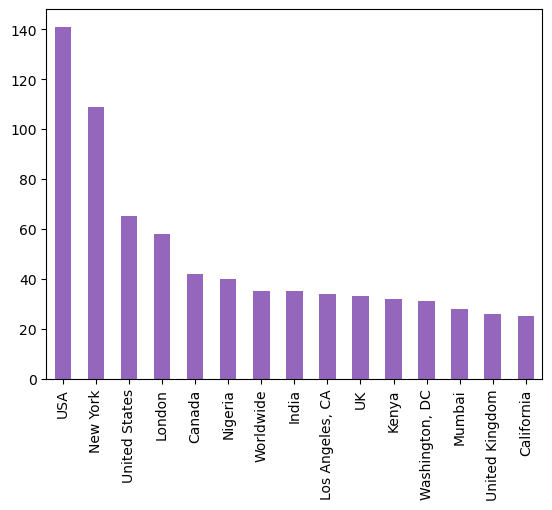

In [6]:
color = sns.color_palette()[4]
df['location'].value_counts()[:15].plot(kind='bar', color=color);

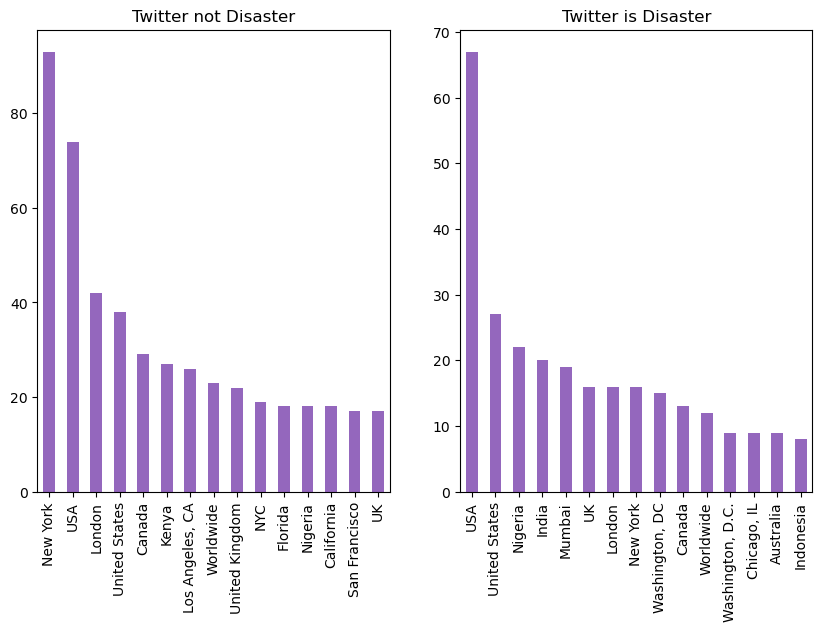

In [7]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.title("Twitter not Disaster")
df[df['target'] == 0]['location'].value_counts()[:15].plot(kind='bar', color=color);
plt.subplot(1,2,2)
plt.title("Twitter is Disaster")
df[df['target'] == 1]['location'].value_counts()[:15].plot(kind='bar', color=color);


Clean Tweets

In [8]:
X = df['text'].values
y = df['target'].values

In [9]:
def cleanTweet():
    corpus=[]
    stop_words = stopwords.words("english")
    stop_words.remove("not")
    pos = PorterStemmer()
    for i in range(0, len(X)):
        tweet = re.sub('[^a-zA-Z0-9]', " ", X[i])
        tweet = tweet.lower()
        wordsInTweet = nltk.word_tokenize(tweet)
        tweet = [pos.stem(word) for word in wordsInTweet if word not in stop_words]
        tweet = " ".join(tweet)
        corpus.append(tweet)
    return corpus

In [10]:
X = cleanTweet()
y = df['target'].values

TF-IDF

In [11]:
tf_vectorizer = TfidfVectorizer()
X = tf_vectorizer.fit_transform(X).toarray()
columns = tf_vectorizer.get_feature_names_out()
df_final = pd.DataFrame(data=X, columns=columns)
df_final.shape

(10876, 23852)

Build Model

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

Logistic Regression

In [13]:
model_log = LogisticRegression()
model_log.fit(X_train, y_train)
y_pred = model_log.predict(X_test)
model_log_accurcy = accuracy_score(y_test, y_pred)

Naive Bayes

In [14]:
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
y_pred = model_nb.predict(X_test)
model_nb_accurcy = accuracy_score(y_test, y_pred)

K-Nearest Neighbors

In [15]:
model_neighbor = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
model_neighbor.fit(X_train, y_train)
y_pred = model_neighbor.predict(X_test)
model_neighbor_accurcy = accuracy_score(y_test, y_pred)

DecisionTree

In [16]:
model_DecisionTree = DecisionTreeClassifier(criterion='entropy',max_depth=2)  
model_DecisionTree.fit(X_train, y_train)
y_pred = model_DecisionTree.predict(X_test)
model_DecisionTree_accurcy = accuracy_score(y_test, y_pred)

Random Forest

In [17]:
model_RandomForest = RandomForestClassifier()
model_RandomForest.fit(X_train, y_train)
y_pred = model_RandomForest.predict(X_test)
model_RandomForest_accurcy = accuracy_score(y_test, y_pred)

In [18]:
df_model = pd.DataFrame({
    'model':['Logistic Regression', 'Naive Bayes', 'K-Nearest Neighbors', 'DecisionTree','Random Forest'],
    'accurcy':[model_log_accurcy, model_nb_accurcy, model_neighbor_accurcy, model_DecisionTree_accurcy, model_RandomForest_accurcy]
})
df_model = df_model.sort_values('accurcy')
df_model

,model,accurcy
1,Naive Bayes,0.559283
3,DecisionTree,0.703585
2,K-Nearest Neighbors,0.740349
4,Random Forest,0.752298
0,Logistic Regression,0.755055


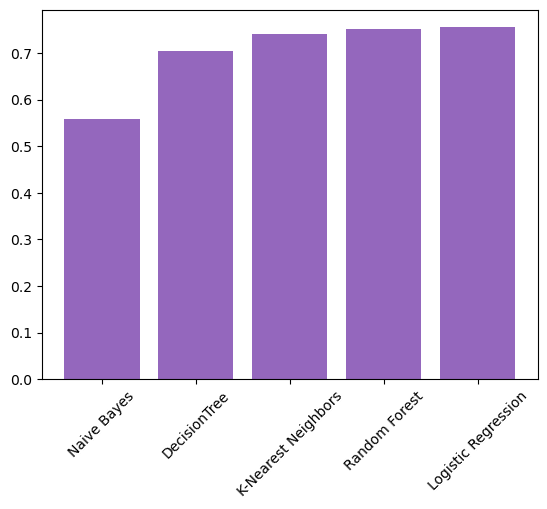

In [19]:
plt.bar(df_model['model'], df_model['accurcy'], color=color)
plt.xticks(rotation=45);

Logistic Regression is the best alghorithm